<h1 style='text-align: center;'> Visualization *in situ*, ground-based measurements with satellite data </h1>


In [49]:
#%pip install regex
# -*- coding: utf-8 -*-
"""
@author: Han Huynh (han.huynh@noaa.gov)
"""

import pandas as pd
from datetime import datetime, timedelta
from copy import deepcopy
import numpy as np
import regex as re
import matplotlib.dates as mdates


import sys
import os

import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import LogFormatter 
import numpy as np

In [50]:
# Basemap to overlay flight track and in situ measurements
#%pip install basemap basemap-data-hires
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from xarray.backends.api import open_datatree
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# -*- coding: utf-8 -*-


## 1. In-situ Measurement Functions

### a) Ingesting _in situ_ aerosol and flight navigation measurement files

In [51]:
"""
Processing flight navigation file (MetNav) in ICARTT format
"""

def read_nav_icartt(nav_icartt_file):
    
    # Revision number
    rev_no = re.search('_R(.+?).ict', nav_icartt_file).group(1)
    if rev_no == 'A':
        alt_col = 'Pressure_Altitude_ft'
        row_no = 39
    elif rev_no == '0':
        alt_col = 'Pressure_Altitude'
        row_no = 75
    elif rev_no == '1':
        alt_col = 'Pressure_Altitude'
        row_no = 76
    else:
        raise Exception('How do we handle revision numbers different from RA and R0 for MetNav ICARTT file?')
    
    # Mid-pint diameter/Dp for each size bin
    nav_df = pd.read_csv(nav_icartt_file, skiprows = row_no)
    nav_cols = nav_df.columns.values.tolist()
    # Remove space from column names
    clean_nav_cols = [s.replace(" ","") for s in nav_cols]
    nav_df.columns = clean_nav_cols
    
    # overwrite all -9999 with Nan
    nav_df.mask(nav_df < -9000, inplace=True)
    
    nan_idx = nav_df.index[(nav_df.iloc[:,1:] < -9000).all(axis=1)]
    if len(nan_idx) != 0:
        raise Exception('There are negative values in MetNav ICARTT file!')
    
    # Calculate altitude in km
    nav_df['Pressure_Altitude_km'] = nav_df[alt_col]*0.0003048
    
    # Get date from file name
    date_string = re.search('DC8_(.+?)_R', nav_icartt_file).group(1)
    start_date = datetime.strptime(date_string, '%Y%m%d')
    
    # Convert time to proper datetime
    nav_df['Time_Start_UTC'] = [float(i) for i in nav_df['Time_Start']]
    
    for i in range(len(nav_df)):
        nav_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = nav_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)
    
    nav_df['Time_Start_UTC'] = pd.to_datetime(nav_df['Time_Start_UTC'], format='%Y-%m-%d %H:%M:%S')
    
    return nav_df



"""
Processing in-situ aerosol microphysical data from a single flight in ICARTT format
"""

def read_amp_icartt(amp_icartt_file):
    
    #amp_icartt_path = icartt_path + r'\AMP'
    # Mid-pint diameter/Dp for each size bin
    amp_size_info = pd.read_csv(amp_icartt_file, skiprows = 127, nrows=0)
    mid_pt_size = amp_size_info.columns.values.tolist()
    s_to_search =  mid_pt_size[0]
    # Grab the first mid-point size
    m = re.search(r'for each channel are:(.*)', s_to_search, re.DOTALL)
    mid_pt_size[0] = m.group(1)
    # Convert the mid-point size from string to float values
    mid_pt_size = [float(i) for i in mid_pt_size]
    
       
    # Stand/end size bin
    amp_size_ct_pt_info = pd.read_csv(amp_icartt_file, skiprows = 128, nrows=0)
    start_end_pt_size = amp_size_ct_pt_info.columns.values.tolist()
    s_to_search =  start_end_pt_size[0]
    # Grab the first mid-point size
    m = re.search(r'for the channel boundaries are:(.*)', s_to_search, re.DOTALL)
    start_end_pt_size[0] = m.group(1)
    # Convert the mid-point size from string to float values
    start_end_pt_size = [float(i) for i in start_end_pt_size]
    
    
    # Bins size information
    # Mid-pt size = extract from ICARTT header
    # Start bin size / end bin size = extract from ICARTT header
    amp_size_df = pd.DataFrame(columns=['Bin_num','mid_pt_dp_nm','start_dp_nm','end_dp_nm'])
    amp_size_df['mid_pt_dp_nm'] = mid_pt_size
    amp_size_df['start_dp_nm'] = start_end_pt_size[:-1]
    amp_size_df['end_dp_nm'] = start_end_pt_size[1:]
    amp_size_df['Bin_num'] = amp_size_df.index.values+1
    amp_size_df = cal_dlogD(amp_size_df)
    
    # Aerosols NUMBER size distribution [=] # / cm3
    # Time UTC
    # dN/dlogDp for each size bin 
    amp_icartt_df = pd.read_csv(amp_icartt_file, skiprows = 131)
    
    # overwrite all -9999 with Nan
    amp_bin_range = amp_icartt_df.columns[1:].values.tolist()
    # Replace negative value < -9000 with NaN
    amp_icartt_df.mask(amp_icartt_df < -9000, inplace=True)
    
    nan_idx = amp_icartt_df.index[(amp_icartt_df.loc[:, amp_bin_range] < -9000).all(axis=1)]
    if len(nan_idx) != 0:
        raise Exception('There are negative values in AMP size distribution!')
        
    
    # Aerosols VOLUME size distribution [=] um3 /cm3
    vol_amp_df = amp_icartt_df.copy()
    for bin_col in amp_bin_range:
        i = amp_bin_range.index(bin_col)
        const = (np.pi/6)*(amp_size_df.loc[i,'mid_pt_dp_nm']*10**-3)**3
        vol_amp_df.loc[:,bin_col] = const*amp_icartt_df.loc[:,bin_col]

    
    return amp_size_df, amp_icartt_df, vol_amp_df


"""
Calculate dlogDp for each bin as (log(D2) - log(D1))/2 + (log(D3) - log(D2))/2 (this example is dlogDp for bin)

"""

def cal_dlogD(amp_size_df):
    
    no_size_bins = len(amp_size_df)
    
    for i in range(no_size_bins):
        
        curr_diam = amp_size_df.loc[i,'mid_pt_dp_nm']*1e-3

        # First bin: NMASS        
        # i = 30 (bin 31, 92.4 nm diameter): UHSAS first bin
        if i in [0, 30]:
            next_diam = amp_size_df.loc[i+1,'mid_pt_dp_nm']*1e-3
            amp_size_df.loc[i,'dlogd'] = np.log10(next_diam) - np.log10(curr_diam)
        
        # last index for the last UHSAS bin
        # i = 29 (bin 30, 84.6 nm diameter): NMASS last bin
        elif i in [29, (no_size_bins - 1)]:
            prev_diam = amp_size_df.loc[i-1,'mid_pt_dp_nm']*1e-3
            amp_size_df.loc[i,'dlogd'] = np.log10(curr_diam) - np.log10(prev_diam)
        else:
            prev_diam = amp_size_df.loc[i-1,'mid_pt_dp_nm']*1e-3
            next_diam = amp_size_df.loc[i+1,'mid_pt_dp_nm']*1e-3
            amp_size_df.loc[i,'dlogd'] = (np.log10(next_diam) - np.log10(curr_diam))/2 + (np.log10(curr_diam) - np.log10(prev_diam))/2   
    
    # For NMASS just average all the dlodDp and apply the same number
    amp_size_df.loc[:29,'dlogd'] = amp_size_df.loc[:29,'dlogd'].mean()
    
    return amp_size_df



"""
Processing in-situ aerosol optical properties measurement from a single flight in ICARTT format
At visible wavelength (405 nm, 532 nm, 664 nm), the following data are available:
+ aerosol extinction
+ aerosol absorption
+ RH-aerosol extinctions at two RH setpoints at 664 nm
"""

def read_aop_icartt(aop_icartt_file):
    
    
    # Mid-pint diameter/Dp for each size bin
    aop_df = pd.read_csv(aop_icartt_file, skiprows = 53)
    aop_cols = aop_df.columns.values.tolist()
    # Remove space from column names
    clean_aop_cols = [s.replace(" ","") for s in aop_cols]
    aop_df.columns = clean_aop_cols 
    
    # overwrite all -9999 with Nan
    # Replace negative value < -9000 with NaN
    aop_df.mask(aop_df < -9000, inplace=True)
    
    nan_idx = aop_df.index[(aop_df.iloc[:, 1:] < -9000).any(axis=1)]
    if len(nan_idx) != 0:
        raise Exception('There are rows with only negative values in AOP ICARTT file!')
    
    # Get date from file name
    date_string = re.search('DC8_(.+?)_R', aop_icartt_file).group(1)
    start_date = datetime.strptime(date_string, '%Y%m%d')
    
    # Convert time to proper datetime
    aop_df['Time_Start_UTC'] = [float(i) for i in aop_df['Time_start']]
    
    for i in range(len(aop_df)):
        aop_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = aop_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)
    
    aop_df['Time_Start_UTC'] = pd.to_datetime(aop_df['Time_Start_UTC'], format='%Y-%m-%d %H:%M:%S')


    return aop_df

### b) Visualization

In [ ]:
# Overlay flight track colored by optical measurements
def visualize_aer_data_map(aer_prop):
    params = {'mathtext.default': 'regular' , 'font.size': 18}          
    plt.rcParams.update(params)
    
    # Make the figure
    fig = plt.figure(figsize=(13, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    #plt.figure(figsize=(14, 14))
    # Initialize the basemap
    m = Basemap(llcrnrlat = 38,
                llcrnrlon = -90,
                urcrnrlat = 44,
                urcrnrlon = -82,
               resolution='h')
    # Get the area of interest imagery
    #m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2500, verbose= True, alpha= .6)
    m.arcgisimage(xpixels = 1500, verbose= True)
    
    # Plot flight track
    #df.plot(column=None, color='springgreen', linewidth=3, alpha=1, categorical=False, legend=False, ax=ax)
    
    # Indicate AERONET site with names
    #for site in aoc_site_list:
        #row = us_aoc_list_df[us_aoc_list_df.site == site]
    co_map = ax.scatter(nav_aop_df.Longitude, nav_aop_df.Latitude, s=10, marker='o', 
                            c=nav_aop_df[aer_prop], cmap='viridis', #vmin=100, vmax=300,
                            norm=mp.colors.LogNorm(vmin=1, vmax=300),
                            #label=flight_path_label, 
                            alpha=0.8)
        
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.1)

    cbar = plt.colorbar(co_map, extend='both')
    c_label = aer_prop + ' ($Mm^{-1}$)'
    cbar.set_label(c_label)
    
    # Draw the coasts
    m.drawcoastlines(color='blue', linewidth=3)
    # Draw the states
    m.drawstates(color='firebrick',linewidth=3)

## 2. Ground-based Measurement (AERONET) Functions

### a) Download AERONET site list for a region

In [ ]:
#%pip install wget

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 27 10:59:45 2022

@author: Maheshwarkar Prem
   
"""

from glob import glob
import wget 

list_path = os.getcwd()

    
def download_aoc_list(region, product, start_date, end_date, output_file_name, level):



    # region = 'ILE_DE_FRANCE', 'FRANCE', 'EUROPE', 'INDIA', 'USA', 'GLOBAL'
    avg = '10'
    #level = '10'
    # start_date = 20220704
    # end_date = 20220706
    download = 'on'  # Keep this on to download the data
    ###############################################################################
    if region == 'FRANCE':
        lat_min = 40; lat_max = 60.0; lon_min = -5.0 ; lon_max = 15.0
    elif region == 'ILE_DE_FRANCE':
        lat_min = 47; lat_max = 50.0; lon_min = 1.0 ; lon_max = 5.0
    # elif region == 'EUROPE':
    #     lat_min = 47; lat_max = 50.0; lon_min = 1.0 ; lon_max = 5.0
    elif region == 'INDIA':
        lat_min = 6; lat_max = 38.0; lon_min = 66.0 ; lon_max = 98.0
    elif region == 'USA':
         lat_min = 24; lat_max = 50.0; lon_min = -125 ; lon_max = -67
    elif region == 'GLOBAL':
        lat_min = -90; lat_max = 90.0; lon_min = -180.0 ; lon_max = 180.0

    ###############################################################################


    __db_path__ = list_path
    if glob(__db_path__+'/sites.csv') == [] :
        wget.download('https://aeronet.gsfc.nasa.gov/aeronet_locations_v3.txt', __db_path__ + '/' + 'sites.csv')

    data = pd.read_csv(__db_path__ + '/sites.csv', skiprows=1, delimiter=',')
    data.rename(columns={'Longitude(decimal_degrees)': 'Longitude', 'Latitude(decimal_degrees)':'Latitude'}, inplace=True)

    data_region = data[(data.Latitude > lat_min) & (data.Latitude < lat_max) & (data.Longitude > lon_min) & (data.Longitude < lon_max)]
    data_region = data_region.reset_index()
    start_date = str(start_date); end_date = str(end_date)
    start_year = start_date[0:4]; start_month = start_date[4:6]; start_day = start_date[6:9] 
    end_year = end_date[0:4]; end_month = end_date[4:6]; end_day = end_date[6:9] 

    [total_station, param] = np.shape(data_region)

    year_initial = [start_year] * total_station
    month_initial = [start_month] * total_station
    day_initial = [start_day] * total_station

    year_final = [end_year]* total_station
    month_final = [end_month]* total_station
    day_final = [end_day]* total_station

    level = [level]* total_station
    avg = avg = [avg]* total_station
    product = [product]* total_station
    download = [download]* total_station

    input_df = pd.DataFrame({'year_initial': year_initial, 'month_initial':month_initial, 'day_initial': day_initial,
                               'year_final':year_final, 'month_final': month_final, 'day_final':day_final,'site': data_region.Site_Name,
                               'level':level, 'avg': avg, 'products':product, 'download':download, 'longitude':data_region.Longitude, 'latitude':data_region.Latitude})

    input_df.to_csv(list_path + '/' + output_file_name + '.csv', index=False)
    
    return input_df
    
    #list_aeronet(region, product,start_date, end_date, output_file_name)


if __name__ == '__download_aoc_region___' :
  import sys
  if len(sys.argv) == 1 :

    print("""Usage: 
             Downloads the list of aeronet stations and prepares input file for download_aeronet.py script.
             :\n args: region start_date end_date output_file_name product\n
             Example :\n
             list_aeronet.py FRANCE 20220616 20220618 FRANCE_ACROSS aod/n
             - siz - Size distribution/n
             - rin	- Refractive indicies (real and imaginary)/n
             - cad -	Coincident AOT data with almucantar retrieval/n
             - vol	- Volume concentration, volume mean radius, effective radius and standard deviation/n
             - tab -	AOD absorption/n
             - aod - AOD extinction/n
             - ssa	- Single scattering albedo/n
             - asy -	Asymmetry factor/n
             - frc -	Radiative Forcing/n
             - lid - Lidar and Depolarization Ratios/n
             - flx - Spectral flux/n
             - pfn - Phase function/n
             - pfncoarse - coarse mode phase functions/n
             - pfnfine - fine mode phase functions/n
             - directsun - Aerosol Optical Depth from AERONET direct sun measurements""")
             
  main(*sys.argv[1:])

    


### b) Download all sites within the specified region

In [ ]:
# -*- coding: utf-8 -*-
#%pip install ssl platform
"""
Imported from GitHub 
https://github.com/fabioslopes/download_aeronet_data/blob/master/aeronet_locations_v3.csv

"""

def download_aoc_sites(input_file_name, inputdatadir):
    name_of_csv_file = input_file_name #'INDIA_COVID'
    # output_file = 'FRANCE_ACROSS' #'INDIA_COVID'
    
    os.chdir(list_path)
    
    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
            ssl._create_default_https_context = ssl._create_unverified_context
    
    '''Creating the folder for raw data download from AERONET web data service'''
    rootdir = list_path
    outputdir = name_of_csv_file
    dircontents = os.sep.join([rootdir, outputdir])
    if not os.path.exists(dircontents):
            os.makedirs(dircontents)
    
    '''Reading the input data to download AERONET data from web data service'''
    inputfilename = name_of_csv_file
    inputdir = os.sep.join([rootdir, inputdatadir])
    filenames = [name for name in os.listdir(inputdir) if name.startswith(inputfilename)]
    nfiles=len(filenames)
    
    print(filenames)
    filenameout = []
    i = 1
    for x in range(0, len(filenames)):
            newfile = os.sep.join([inputdir, filenames[x]])
            if platform.system() == 'Linux':
                filedata = pd.read_csv(newfile)
            else:
                filedata = pd.read_csv(newfile, sep=',' )
                    
            for i in range(0,len(filedata)):
                if filedata['download'][i] == 'on':
                                                
                    if filedata['month_initial'][i] < 10: 
                            filemonthin = '0'+ str(filedata['month_initial'][i])
                    else:
                            filemonthin = str(filedata['month_initial'][i])
                    if filedata['month_final'][i] < 10:
                            filemonthfinal = '0'+ str(filedata['month_final'][i])
                    else:
                            filemonthfinal = str(filedata['month_final'][i])
                    if filedata['day_initial'][i] < 10: 
                            filedayin = '0'+ str(filedata['day_initial'][i])
                    else:
                            filedayin = str(filedata['day_initial'][i])
                    if filedata['day_final'][i] < 10:
                            filedayfinal = '0'+ str(filedata['day_final'][i])
                    else:
                            filedayfinal = str(filedata['day_final'][i])
                    if filedata['level'][i] == 10:
                            filelevel = '10'
                    elif filedata['level'][i] == 15:
                            filelevel = '15'
                    else:
                            filelevel = '20'  
                    # filenameout = str(filedata['year_initial'][i])+filemonthin+filedayin+'_'+\
                    #               str(filedata['year_final'][i])+filemonthfinal+filedayfinal+'_'+\
                    #               filedata['site'][i]+'_level'+filelevel+'.'+filedata['products'][i]
                    
                    filenameout = filedata['site'][i]
                    
                    url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?site='+filedata['site'][i]+\
                          '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                          '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                          '&product='+filedata['products'][i].upper()+'&AVG='+str(filedata['avg'][i])+'&ALM'+filelevel+'=1&if_no_html=1'
                    
                    if filedata['products'][i] == 'pfncoarse':
                            url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?site='+filedata['site'][i]+\
                                  '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                                  '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                                  '&product=PFN&AVG='+str(filedata['avg'][i])+'&ALM'+filelevel+'=1&if_no_html=1&pfn_type=1'
    
                    if filedata['products'][i] == 'pfnfine':                                
                            url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_inv_v3?site='+filedata['site'][i]+\
                                  '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                                  '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                                  '&product=PFN&AVG='+str(filedata['avg'][i])+'&ALM'+filelevel+'=1&if_no_html=1&pfn_type=2'
    
                    if filedata['products'][i] == 'directsun':
                            url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site='+filedata['site'][i]+\
                                    '&year='+str(filedata['year_initial'][i])+'&month='+filemonthin+'&day='+filedayin+\
                                    '&year2='+str(filedata['year_final'][i])+'&month2='+filemonthfinal+'&day2='+filedayfinal+\
                                    '&AOD'+filelevel+'=1&AVG='+str(filedata['avg'][i])
                                            
                    filename = wget.download(url, out=os.sep.join([dircontents, filenameout]))
                    print(url)
                    print('downloading....%s of %s files.'%(i, len(filedata)))
                    i = i+1

if __name__ == '__download_aoc_sites__' :
  import sys
  if len(sys.argv) == 1 :

    print("""Usage: 
             Downloads the data from aeronet stations based on list_aeronet.py script.
             :\n args: input_file_name\n
             Example :\n
             download_aeronet.py ACROSS_FRANCE""")
             
  main(*sys.argv[1:])


# 1. Prep in-situ aerosol measurement

/tmp/ipykernel_5342/2139896452.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2023-08-02 14:50:13' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  nav_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = nav_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)
/tmp/ipykernel_5342/2139896452.py:189: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2023-08-02 14:50:13' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  aop_df.loc[i, 'Time_Start_UTC'] = (start_date + timedelta(seconds = aop_df.loc[i, 'Time_Start_UTC'])).replace(microsecond = 0)# - relativedelta(minutes=6)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-90.0,38.0,-82.0,44.0&bboxSR=4326&imageSR=4326&size=1500,1125&dpi=96&format=png32&transparent=true&f=image


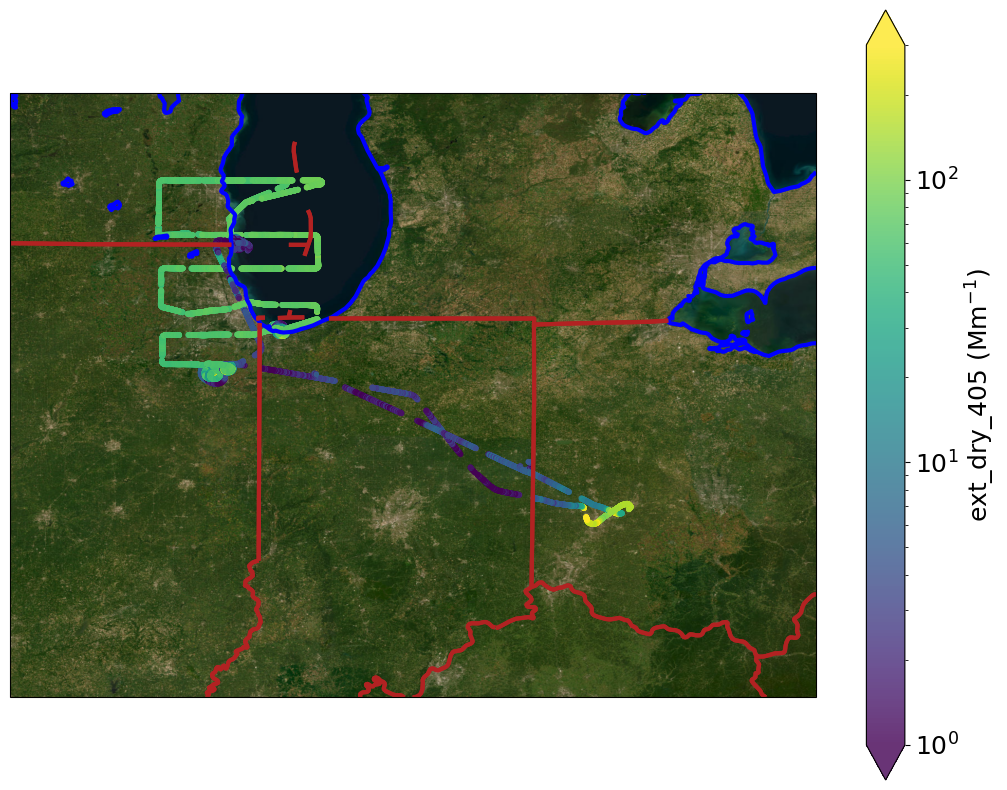

In [55]:
"""
MetNav data = flight data
"""
nav_icartt_file = 'AEROMMA-MetNav_DC8_20230802_R0.ict'
nav_df = read_nav_icartt(nav_icartt_file)

# Extract flight date from file name
flight_date = re.search('DC8_(.+?)_R', nav_icartt_file).group(1)

"""
Aerosol optical properties data
"""
aop_icartt_file = 'AEROMMA-AOP-Optical_DC8_20230802_R0.ict'
aop_df = read_aop_icartt(aop_icartt_file)

# Visualize the flight path colored by measured aerosol extinction
nav_aop_df = aop_df.merge(nav_df, how='left', left_on = 'Time_start', right_on='Time_Start', suffixes=('', '_y'))

# Visualize the flight path colored by measured aerosol extinction (e.g., dry extinction at 405-nm)
visualize_aer_data_map('ext_dry_405')

# 2. Prep satellite data measurement

## a) PACE testing AOT data

In [56]:
import earthaccess
import xarray as xr

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from copy import deepcopy
import numpy as np
import matplotlib.dates as mdates


import sys
import os

import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [57]:
# Sample aerosol AOT/AOD data (daily at 1 degree)
sample_aod = 'PACE_OCI.20240704.L3m.DAY.AER_DB.V2_0.aot_490_db.1deg.NRT.nc'
sample_aod_dataset = xr.open_dataset(sample_aod)


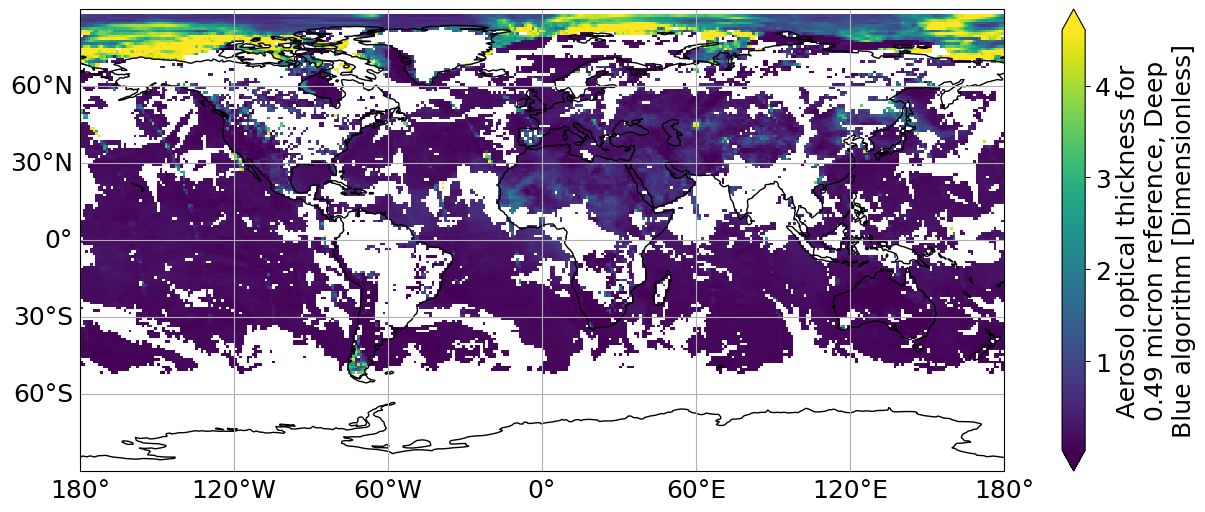

In [58]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
sample_aod_dataset["aot_490_db"].plot(x="lon", y="lat", cmap="viridis", ax=ax, robust=True)


## b) MODIS/VIIRS? AOT data

In [10]:
auth = earthaccess.login(persist=True)

In [11]:
tspan = ("2023-08-02 00:00:00", "2023-08-02 23:59:59")
    
results = earthaccess.search_data(
    short_name="AERDB_D3_VIIRS_NOAA20",
    temporal=tspan
)    

In [14]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
sample_viirs_df = xr.open_dataset(paths[1])
sample_viirs_df

<xarray.Dataset> Size: 24MB
Dimensions:                                                      (
                                                                  Latitude_1D: 180,
                                                                  Longitude_1D: 360,
                                                                  Aerosol_Types: 8,
                                                                  Land_Bands: 3,
                                                                  Ocean_Bands: 7)
Coordinates:
  * Aerosol_Types                                                (Aerosol_Types) int32 32B ...
  * Land_Bands                                                   (Land_Bands) float32 12B ...
    Latitude                                                     (Latitude_1D, Longitude_1D) float32 259kB ...
  * Latitude_1D                                                  (Latitude_1D) float32 720B ...
    Longitude                                                    (Latitude_1D, Longitude_1D) float32 259kB ...
  * Longitude_1D                                                 (Longitude_1D) float32 1kB ...
  * Ocean_Bands                                                  (Ocean_Bands) float32 28B ...
Data variables: (12/38)
    Aerosol_Optical_Thickness_550_Land_Count                     (Latitude_1D, Longitude_1D) float64 518kB ...
    Aerosol_Optical_Thickness_550_Land_Maximum                   (Latitude_1D, Longitude_1D) float32 259kB ...
    Aerosol_Optical_Thickness_550_Land_Mean                      (Latitude_1D, Longitude_1D) float32 259kB ...
    Aerosol_Optical_Thickness_550_Land_Minimum                   (Latitude_1D, Longitude_1D) float32 259kB ...
    Aerosol_Optical_Thickness_550_Land_Ocean_Count               (Latitude_1D, Longitude_1D) float64 518kB ...
    Aerosol_Optical_Thickness_550_Land_Ocean_Maximum             (Latitude_1D, Longitude_1D) float32 259kB ...
    ...                                                           ...
    Spectral_Aerosol_Optical_Thickness_Land_Mean                 (Land_Bands, Latitude_1D, Longitude_1D) float32 778kB ...
    Spectral_Aerosol_Optical_Thickness_Land_Standard_Deviation   (Land_Bands, Latitude_1D, Longitude_1D) float32 778kB ...
    Spectral_Aerosol_Optical_Thickness_Ocean_Count               (Ocean_Bands, Latitude_1D, Longitude_1D) float64 4MB ...
    Spectral_Aerosol_Optical_Thickness_Ocean_Mean                (Ocean_Bands, Latitude_1D, Longitude_1D) float32 2MB ...
    Spectral_Aerosol_Optical_Thickness_Ocean_Standard_Deviation  (Ocean_Bands, Latitude_1D, Longitude_1D) float32 2MB ...
    Unsuitable_Pixel_Fraction_Land_Ocean                         (Latitude_1D, Longitude_1D) float32 259kB ...
Attributes: (12/58)
    description:                       NOAA20 VIIRS Deep Blue Level 3 daily a...
    comment:                           Data are the arithmetic mean of all NO...
    references:                        https://deepblue.gsfc.nasa.gov
    institution:                       NASA Goddard Space Flight Center
    long_name:                         NOAA20 VIIRS Deep Blue Level 3 daily a...
    production_datetime:               2023-08-06T00:06:36Z
    ...                                ...
    creator_institution:               Space Science & Engineering Center, Un...
    publisher_name:                    LAADS
    publisher_url:                     https://ladsweb.modaps.eosdis.nasa.gov/
    publisher_email:                   modis-ops@lists.nasa.gov
    publisher_institution:             NASA Level-1 and Atmosphere Archive & ...
    xmlmetadata:                       <?xml version="1.0"?>\n<!DOCTYPE Granu...

# 3. Prep ground-based aerosol measurement (AERONET)

In [20]:
"""
Example: download a list of AERONET sites in the US region that has AOD data in the specified date range at the specified data level

"""
region_name = 'USA'
data_product = 'aod'
start_date = '20230601'
end_date = '20230831'
region_aoc_summary_file_name = 'USA_AOD_AERONET_sites'
data_level = '10'

# There will be a generated .csv with the list of AERONET sites but also a dataframe that houses that information
us_aoc_list_df = download_aoc_list(region_name, data_product, start_date, end_date, region_aoc_summary_file_name, data_level)

In [ ]:
"""
Example: download all AOD data for the specified time range for each individual AERONET sites 
"""
# Name of the folder to house all individual AERONET sites

inputdatadir = 'AERONET_US_sites'
download_aoc_sites(region_aoc_summary_file_name, inputdatadir)

# 4. Overlay _in situ_, ground-based, and satellite aerosol data

## a) Overlay .kml flight tracks on top of satellite data

First, we processed .kml or .kmz into a GeoDataFrame. The function `impose_flight_track_pace_data` then plots the flight track over a US map. If latitude and longitude limits (min or max) are specified, the graph will resize accordingly. Note that these limits are optional requirements.

In [60]:
#%pip install geopandas fiona

# Required packages
import cartopy.feature as cfeature
import geopandas as gpd
#from shapely.geometry import Point, Polygon
from fiona.drvsupport import supported_drivers

  Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x86_64.whl.metadata (50 kB)
Using cached fiona-1.9.6-cp310-cp310-manylinux2014_x86_64.whl (15.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [61]:
# Process kml file
def read_flight_track(kml_filename):

    supported_drivers['LIBKML'] = 'rw'
    df = gpd.read_file(kml_filename)
    
    return df


# Create a figure and an axes with a specific projection
def impose_flight_track_pace_data(plotted_data, flight_track_df, lat_min=None, lat_max=None, lon_min=None, lon_max=None):

    fig = plt.figure(figsize=(15, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    plotted_data.plot(x="lon", y="lat", cmap="plasma", ax=ax, robust=True)
    flight_track_df.loc[[0],'geometry'].plot(cmap='cubehelix', alpha=1, ax=ax)

    
    # Add features to the map
    ax.add_feature(cfeature.STATES, edgecolor='blue')  # Add state boundaries with black edges
    ax.add_feature(cfeature.BORDERS, linestyle='--')  # Add country borders with dashed lines
    ax.add_feature(cfeature.COASTLINE)  # Add coastline
    
    # Add gridlines (optional)
    ax.gridlines(draw_labels=True, linewidth=0.2)
    
    # Set extent to focus on the US
    #ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # [min_longitude, max_longitude, min_latitude, max_latitude]
    
    # Zoom in only if lat/lon min/max values are passed
    if not lat_min:
        # Set extent to focus on the US
        ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())  # [min_longitude, max_longitude, min_latitude, max_latitude]

    else:
        # Zoom in   
        ax.set_xlim(lat_min,lat_max)
        ax.set_ylim(lon_min, lon_max)
        ax.set_aspect('equal')
    
    # Title and show the plot
    #plt.title('Map of the US with State Lines')
    plt.show()


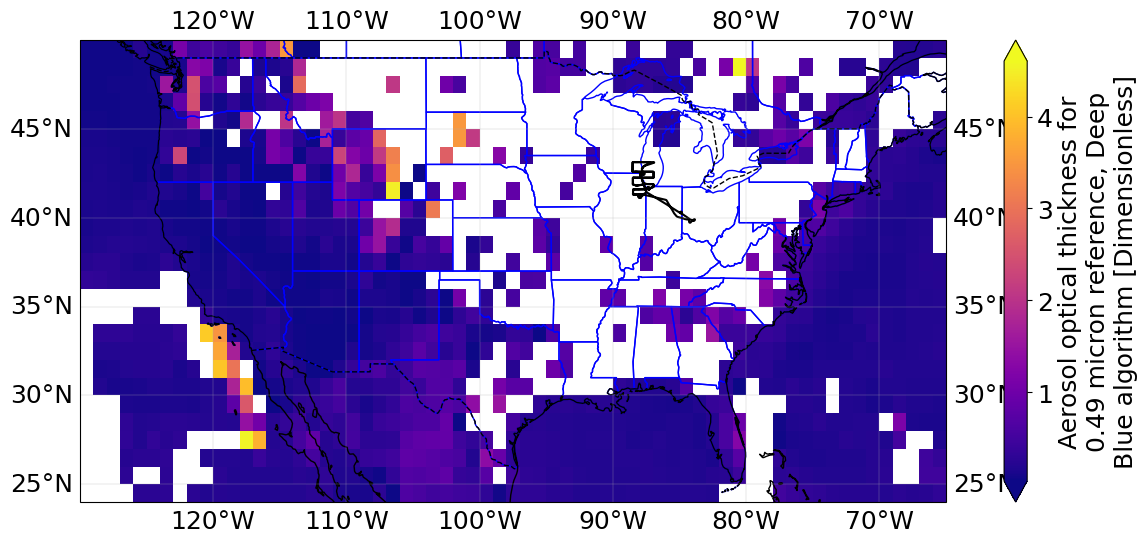

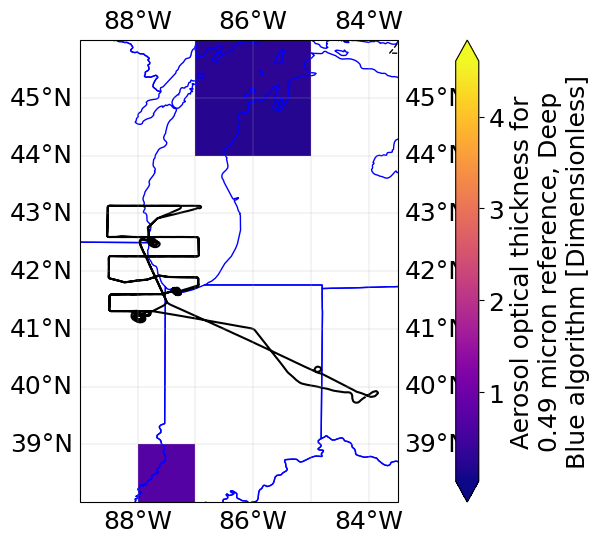

In [62]:
"""
An example of a Chicago flight track overlaid on a heatmap of AOT at 0.49 um: 
(top) US-top-view
(bottom) zoomed in Chicago area

"""

# Pass in a kml_filename for a Chicago flight
flight_track_df = read_flight_track('AEROMMA_FltTrack_20230802.kml')

# full US view
impose_flight_track_pace_data(sample_aod_dataset["aot_490_db"], flight_track_df)

# zoomed-in
lat_min = 38
lat_max = 46
lon_min = -89
lon_max = -83.5
impose_flight_track_pace_data(sample_aod_dataset["aot_490_db"], flight_track_df, lon_min, lon_max, lat_min, lat_max)

## b) Overlay AERONET sites closest to the flight track on the map

In [63]:
# Get a list of AERONET locations closest to flight tracks
def get_nearest_aoc_sites(lon_min, lon_max, lat_min, lat_max):
    aoc_site_list = []
    for i in range(len(us_aoc_list_df)):
        site = us_aoc_list_df.loc[i, 'site']
        longitude = us_aoc_list_df.loc[i, 'longitude']
        latitude = us_aoc_list_df.loc[i, 'latitude']
        
        if (lon_min <= longitude <= lon_max) & (lat_min <= latitude <= lat_max):
            aoc_site_list.append(site)
    
    # Get the corresponding subset of US AERONET sites
    filtered_us_aoc_list_df = us_aoc_list_df[us_aoc_list_df['site'].isin(aoc_site_list)].reset_index(drop=True)
    
    return filtered_us_aoc_list_df

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-90.0,38.0,-82.0,44.0&bboxSR=4326&imageSR=4326&size=1500,1125&dpi=96&format=png32&transparent=true&f=image


NameError: name 'df' is not defined

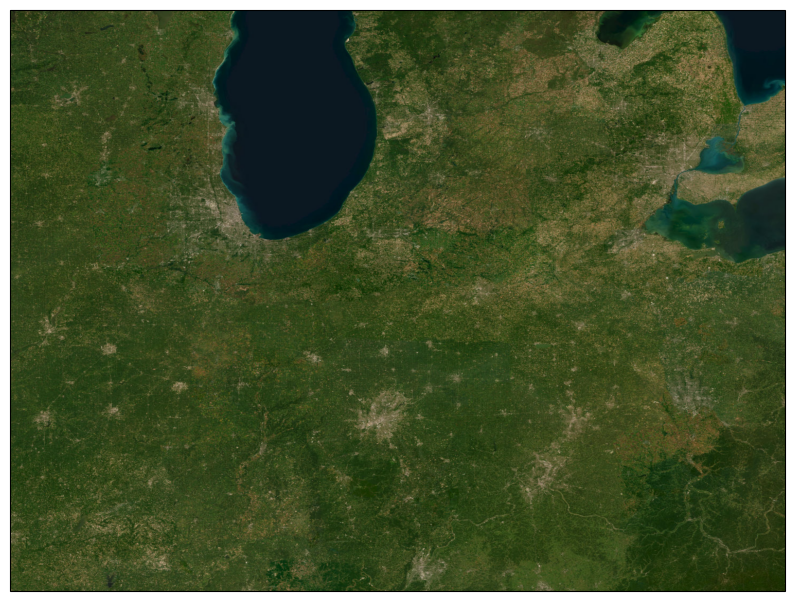

In [64]:
# Make the figure
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.figure(figsize=(14, 14))
# Initialize the basemap
m = Basemap(llcrnrlat = 38,
            llcrnrlon = -90,
            urcrnrlat = 44,
            urcrnrlon = -82,
           resolution='h')
# Get the area of interest imagery
#m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2500, verbose= True, alpha= .6)
m.arcgisimage(xpixels = 1500, verbose= True)

# Plot flight track
df.plot(column=None, color='springgreen', linewidth=3, alpha=1, categorical=False, legend=False, ax=ax)

# Indicate AERONET site with names
#for site in aoc_site_list:
    #row = us_aoc_list_df[us_aoc_list_df.site == site]
m.scatter(filtered_us_aoc_list_df['longitude'], filtered_us_aoc_list_df['latitude'], marker='*', s=250, color='magenta')


# Annotate each point
aoc_site_list = filtered_us_aoc_list_df['site'].values 
for i, label in enumerate(aoc_site_list):
    ax.annotate(label, (filtered_us_aoc_list_df['longitude'][i], filtered_us_aoc_list_df['latitude'][i]), 
                textcoords="offset points", xytext=(0,5), ha='center',
                fontsize=10, color='violet', fontweight='bold')


# Draw the coasts
m.drawcoastlines(color='blue', linewidth=3)
# Draw the states
m.drawstates(color='firebrick',linewidth=3)

In [67]:
aoc_folder_name = 'AERONET_US_sites'
aoc_dir = os.path.join(os.getcwd(), aoc_folder_name)

In [72]:
all_aoc_file_names = os.listdir(aoc_dir)
filtered_list = [s for s in all_aoc_file_names if any(sub in s for sub in aoc_site_list)]

filtered_list

['20230601_20230731_Kellogg_LTER_level15.aod',
 '20230601_20230731_BONDVILLE_level15.aod',
 '20230601_20230731_South_Greenbay_level15.aod',
 '20230601_20230731_Dayton_level15.aod',
 '20230601_20230731_LMOS_Zion_Site_level15.aod']

In [21]:
#import geopandas as gpd
import geodatasets

nybb = gpd.read_file(geodatasets.get_path("nybb"))
chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))
groceries = gpd.read_file(geodatasets.get_path("geoda.groceries")).explode(ignore_index=True)

Extracting 'nybb_16a/nybb.shp' from '/home/jovyan/.cache/geodatasets/nybb_16a.zip' to '/home/jovyan/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/home/jovyan/.cache/geodatasets/nybb_16a.zip' to '/home/jovyan/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/home/jovyan/.cache/geodatasets/nybb_16a.zip' to '/home/jovyan/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/home/jovyan/.cache/geodatasets/nybb_16a.zip' to '/home/jovyan/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'chicago_commpop/chicago_commpop.geojson' from '/home/jovyan/.cache/geodatasets/chicago_commpop.zip' to '/home/jovyan/.cache/geodatasets/chicago_commpop.zip.unzip'
Extracting 'grocery/chicago_sup.shp' from '/home/jovyan/.cache/geodatasets/grocery.zip' to '/home/jovyan/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.dbf' from '/home/jovyan/.cache/geodatasets/grocery.zip' to '/home/jovyan/.cache/geodatasets/gr

In [22]:
nybb.explore()

<Axes: >

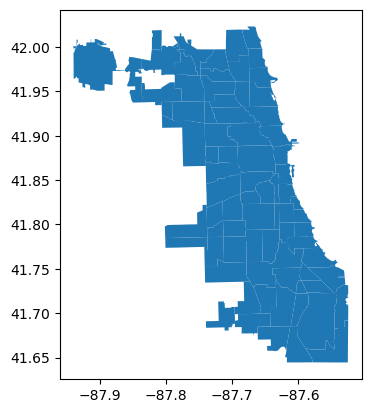

In [29]:
chicago.plot()